# Group Number: 32
# Student 1: Andrei Rykov
# Student 2: Nikita Jain
# Student 3: Ryan Meghoe

In [1]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [3]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


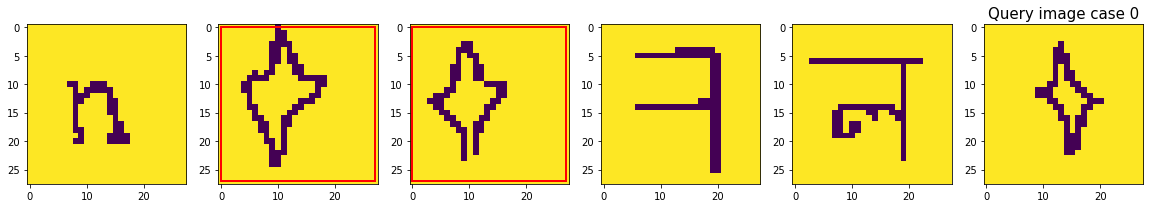

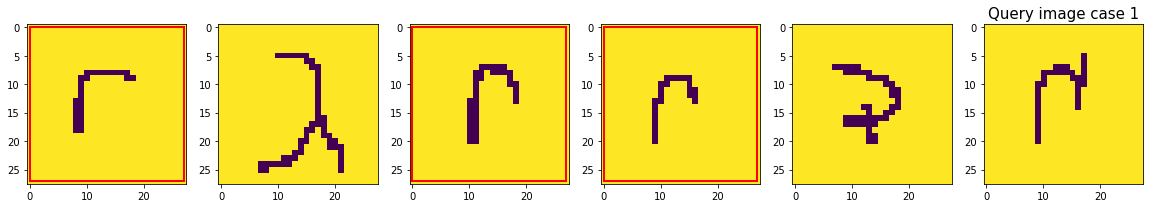

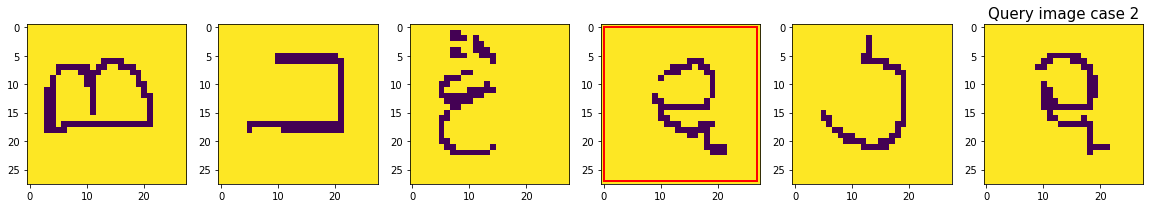

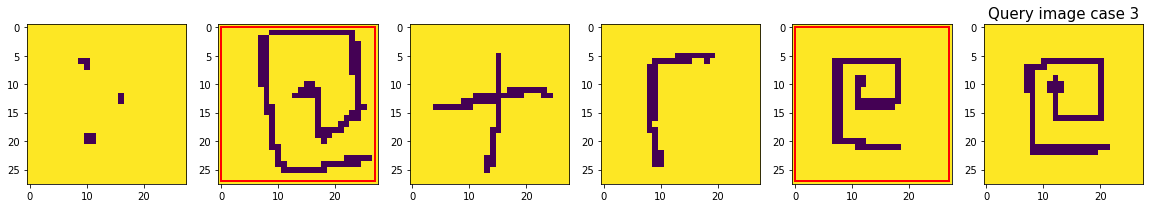

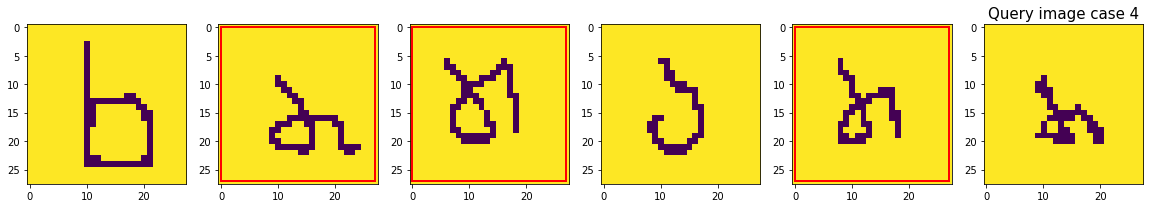

In [4]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [5]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



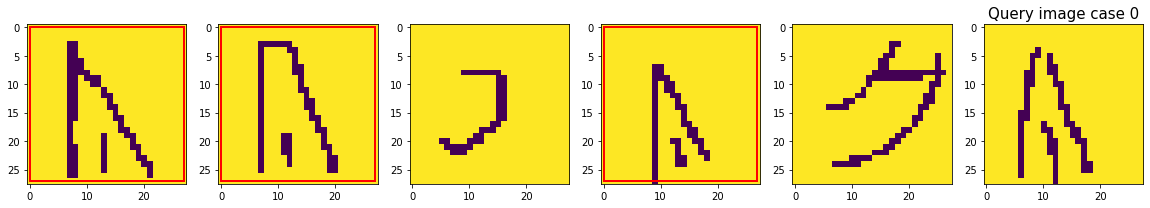

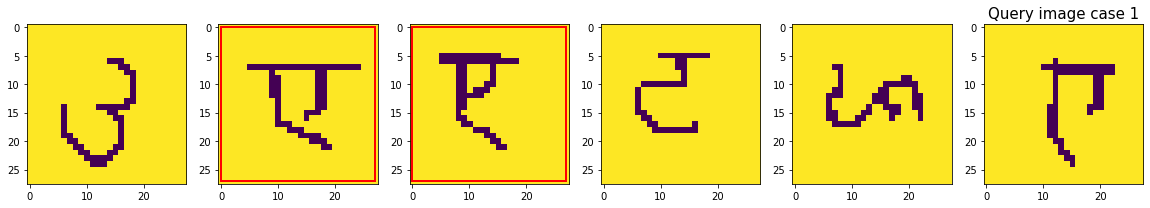

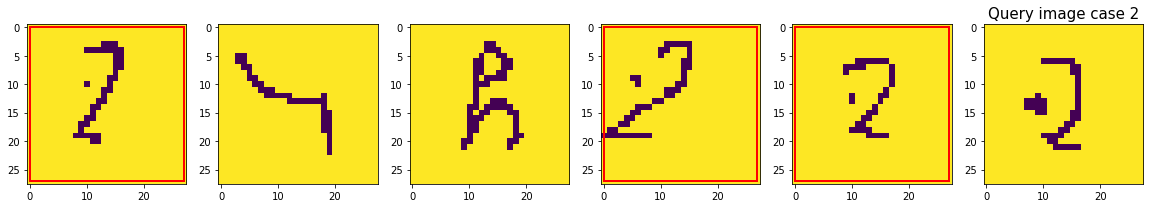

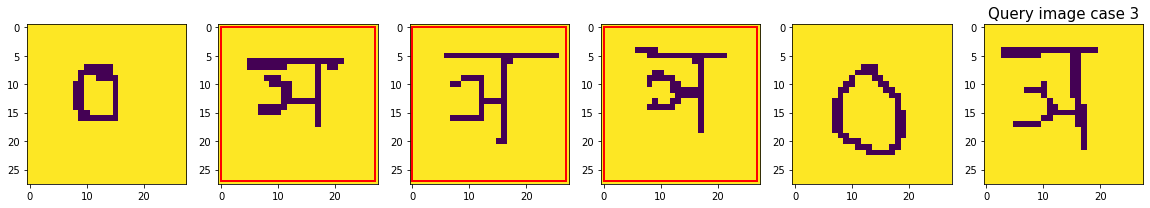

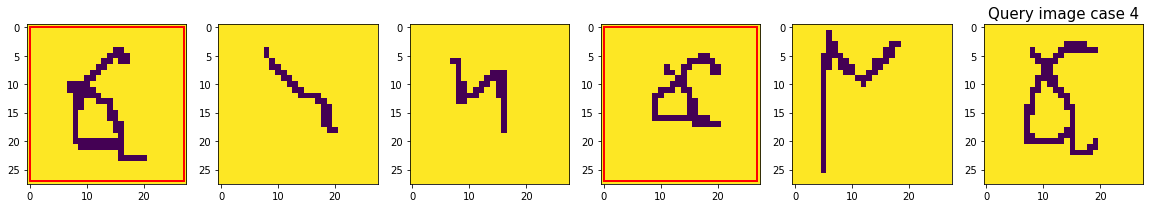

In [6]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [7]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image


class TrainProcessDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        The dataset initialization

        Args:
            data (np.ndarray): images vector of expectied size (number of vectors, size of support set + 1, height, width)
            targets (np.ndarray): labels vector of expected size (number of vectors, size of support set)
            transform (callable, optional): Optional transform to be applied on a sample
        """
        # load images of shape (x, 6, 28, 28)
        # load labels of shape (x, 5) 
        
        #x = torch.zeros([data.shape[0]*(data.shape[1]- 1), 2, data.shape[-2], data.shape[-1]], dtype=torch.float64)
        #y = torch.zeros([data.shape[0]*(data.shape[1]- 1), 1], dtype=torch.long)
        x = np.zeros((data.shape[0]*(data.shape[1]- 1), 2, data.shape[-2], data.shape[-1]))
        y = np.zeros((data.shape[0]*(data.shape[1]- 1), 1))

        for n, (images, targets) in enumerate(zip(data, targets)):
             for i in range(data.shape[1]- 1):
                 x[n*(data.shape[1]- 1)+i, 0] = images[i]
                 x[n*(data.shape[1]- 1)+i, 1] = images[-1]
                 y[n*(data.shape[1]- 1)+i] = targets[i]

        # store images as pairs of one example from support vector and the query image (5x, 2, 28, 28)
        self.data = torch.Tensor(x)
        # store the labels as 0/1 array
        self.targets = torch.Tensor(y)
        # 
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            im1 = self.data[index][0]
            im1 = self.transform(im1.reshape((1,im1.shape[0], im1.shape[1]))).reshape((self.data.shape[-2],self.data.shape[-1]))
            im2 = self.data[index][1]
            im2 = self.transform(im2.reshape((1,im2.shape[0], im2.shape[1]))).reshape((self.data.shape[-2],self.data.shape[-1]))
        else:
            im1 = self.data[index][0]
            im2 = self.data[index][1]
        return im1, im2, self.targets[index]
    
    def __len__(self):
        return len(self.data)

    def __shape__(self):
        return self.data.shape, self.targets.shape
    

def train_validation_split(X: np.ndarray, Y: np.ndarray, train_size = 0.8, transform = None):
    """
    The function that returns the train and validation datasets
    Args:
        X (np.ndarray): the feature matrix
        Y (np.ndarray): the labels matrix
    
    Output:
        Train (TrainProcessDataset): the object of class TrainProcessDataset with train data
        Validation (TrainProcessDataset): the object of class TrainProcessDataset with validation data
    """
    indices = list(SubsetRandomSampler(range(X.shape[0])))
    train_X, train_Y = X[:int(np.floor(len(indices)*train_size))], Y[:int(np.floor(len(indices)*train_size))]
    val_X, val_Y = X[int(np.floor(len(indices)*train_size)):], Y[int(np.floor(len(indices)*train_size)):]
    return TrainProcessDataset(train_X, train_Y, transform), TrainProcessDataset(val_X, val_Y, transform)

## The Model

In [8]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

## Model Definition ##
class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
             #1
            nn.Conv2d(1, 64, 3), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  
            nn.BatchNorm2d(64),
            #2
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),   
            nn.MaxPool2d(2),   
            nn.BatchNorm2d(128),
            #3
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.liner = nn.Sequential(nn.Linear(3*3*256, 128), nn.Sigmoid())
        self.out = nn.Linear(128, 1)

    def forward_one(self, x):
        #print(x.shape)
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = torch.sigmoid(self.out(dis))
     
        return out 

In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_training(training_loss, valid_loss, name):

    clear_output()

    plt.figure(figsize=(12, 8))
    plt.title(f'{name} optimisation')
    plt.xlabel('epoch')
    plt.ylabel(f'{name}')
    plt.plot(training_loss, label=f'Training {name}')
    plt.plot(valid_loss, label=f'Validation {name}')
    plt.xticks(np.arange(0, len(training_loss)), labels = np.arange(1, len(training_loss)+1))
    plt.grid()
    plt.legend()
    plt.show()

In [16]:
## Training ##

from tqdm import tqdm

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

        epoch_train_losses = []
        epoch_val_losses = []
        epoch_train_accuracy = []
        epoch_val_accuracy = []
        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for A, B, y in self.training_DataLoader:

                A, B, target = A.reshape(-1, 1, 28, 28).to(self.device), B.reshape(-1, 1, 28, 28).to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                #print(A.shape)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(A, B)  # one forward pass

                loss = self.criterion(out, target)  # calculate loss
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

                correct += (torch.round(out) == target).sum().item()
                length += target.shape[0]
            
            epoch_train_losses.append(np.mean(train_losses))
            epoch_train_accuracy.append(np.round(correct/length, 5))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for A, B, y in self.validation_DataLoader:

                A, B, target = A.reshape(-1, 1, 28, 28).to(self.device), B.reshape(-1, 1, 28, 28).to(self.device), y.to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(A, B)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

                    correct += (torch.round(out) == target).sum().item()
                    length += target.shape[0]
            epoch_val_losses.append(np.mean(valid_losses))
            epoch_val_accuracy.append(np.round(correct/length, 5))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses, epoch_train_accuracy, epoch_val_accuracy
        
    def evaluate(self):

        self.model.eval()

        with torch.no_grad():
            correct = 0
            length = 0
            for A, B, y in self.testing_DataLoader:

                A, B, target = A.reshape(-1, 1, 28, 28).to(self.device), B.reshape(-1, 1, 28, 28).to(self.device), y.to(self.device)

                out = self.model(A, B)

                correct += (torch.round(out) == target).sum().item()
                length += target.shape[0]
            
        print(f'Accuracy: {correct/length:.4f}',end=' ')

## Experiment with original data with Binary Cross-Entropy Loss

In [17]:
# Load the dataset
train_dataset, val_dataset = train_validation_split(train_data, train_label, train_size=0.8, transform = None)
test_dataset = TrainProcessDataset(test_data, test_label)

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = Siamese().to(device)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

TrainingProcedure = Trainer(model, device, criterion, optimizer, train_loader, val_loader, test_loader, epochs = 20)

train_loss, val_loss, train_accuracy, val_accuracy = TrainingProcedure.run_trainer()

  5%|▌         | 1/20 [00:22<07:01, 22.20s/it]

EPOCH: 01/20 LOSS: 0.5129 VAL-LOSS: 0.3531


 10%|█         | 2/20 [00:44<06:37, 22.09s/it]

EPOCH: 02/20 LOSS: 0.3022 VAL-LOSS: 0.2429


 15%|█▌        | 3/20 [01:06<06:15, 22.08s/it]

EPOCH: 03/20 LOSS: 0.1734 VAL-LOSS: 0.2024


 20%|██        | 4/20 [01:28<05:54, 22.15s/it]

EPOCH: 04/20 LOSS: 0.0853 VAL-LOSS: 0.1825


 25%|██▌       | 5/20 [01:50<05:31, 22.12s/it]

EPOCH: 05/20 LOSS: 0.0383 VAL-LOSS: 0.1736


 30%|███       | 6/20 [02:12<05:10, 22.16s/it]

EPOCH: 06/20 LOSS: 0.0195 VAL-LOSS: 0.1707


 35%|███▌      | 7/20 [02:35<04:48, 22.22s/it]

EPOCH: 07/20 LOSS: 0.0121 VAL-LOSS: 0.1722


 40%|████      | 8/20 [02:57<04:27, 22.29s/it]

EPOCH: 08/20 LOSS: 0.0086 VAL-LOSS: 0.1733


 45%|████▌     | 9/20 [03:20<04:07, 22.47s/it]

EPOCH: 09/20 LOSS: 0.0066 VAL-LOSS: 0.1752


 50%|█████     | 10/20 [03:42<03:44, 22.46s/it]

EPOCH: 10/20 LOSS: 0.0054 VAL-LOSS: 0.1767


 55%|█████▌    | 11/20 [04:06<03:23, 22.66s/it]

EPOCH: 11/20 LOSS: 0.0045 VAL-LOSS: 0.1782


 60%|██████    | 12/20 [04:29<03:02, 22.86s/it]

EPOCH: 12/20 LOSS: 0.0038 VAL-LOSS: 0.1796


 65%|██████▌   | 13/20 [04:52<02:41, 23.00s/it]

EPOCH: 13/20 LOSS: 0.0033 VAL-LOSS: 0.1810


 70%|███████   | 14/20 [05:15<02:17, 22.92s/it]

EPOCH: 14/20 LOSS: 0.0029 VAL-LOSS: 0.1823


 75%|███████▌  | 15/20 [05:37<01:53, 22.80s/it]

EPOCH: 15/20 LOSS: 0.0026 VAL-LOSS: 0.1834


 80%|████████  | 16/20 [06:00<01:30, 22.70s/it]

EPOCH: 16/20 LOSS: 0.0023 VAL-LOSS: 0.1846


 85%|████████▌ | 17/20 [06:22<01:07, 22.65s/it]

EPOCH: 17/20 LOSS: 0.0021 VAL-LOSS: 0.1856


 90%|█████████ | 18/20 [06:45<00:45, 22.55s/it]

EPOCH: 18/20 LOSS: 0.0019 VAL-LOSS: 0.1865


 95%|█████████▌| 19/20 [07:07<00:22, 22.42s/it]

EPOCH: 19/20 LOSS: 0.0018 VAL-LOSS: 0.1874


100%|██████████| 20/20 [07:29<00:00, 22.48s/it]

EPOCH: 20/20 LOSS: 0.0017 VAL-LOSS: 0.1883


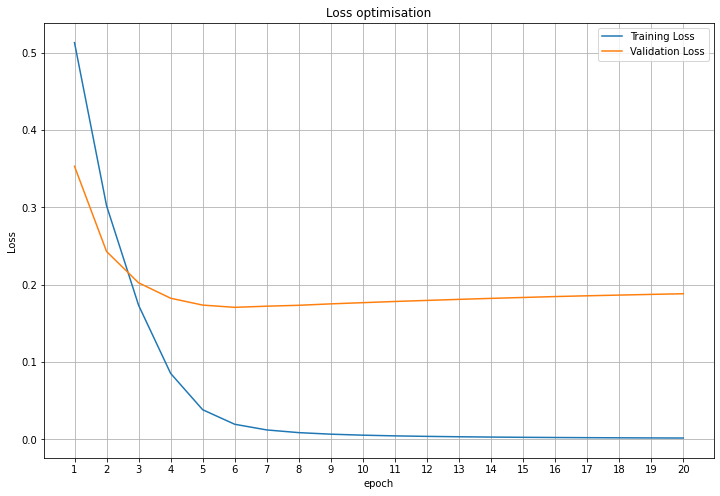

In [20]:
plot_training(train_loss, val_loss, 'Loss')

Check the accuracy

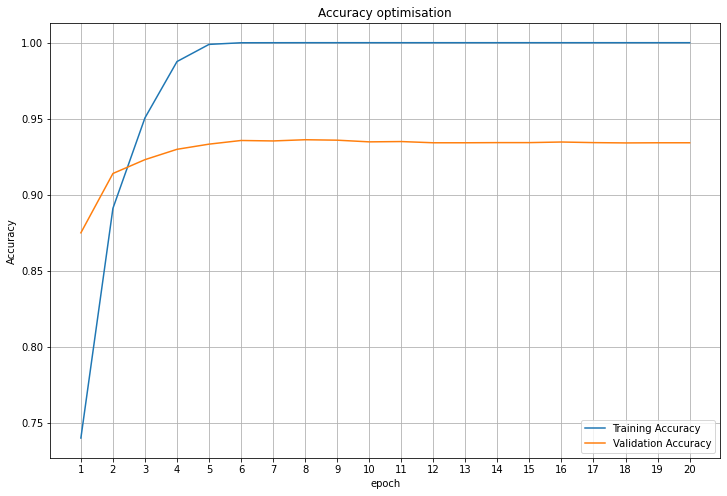

In [21]:
plot_training(train_accuracy, val_accuracy, 'Accuracy')

In [22]:
TrainingProcedure.evaluate()

Accuracy: 0.9056 

## Experiment with data augmentation with Binary Cross-Entropy Loss

#### Loading the data

In [23]:
from torchvision import transforms
augmentation = transforms.RandomAffine(degrees = (-20, 20), translate=(0.2, 0.2), scale=(0.9, 1.15), fill  = 1)

In [24]:
train_dataset, val_dataset = train_validation_split(train_data, train_label, train_size=0.8, transform = augmentation)

The examples of the transformations

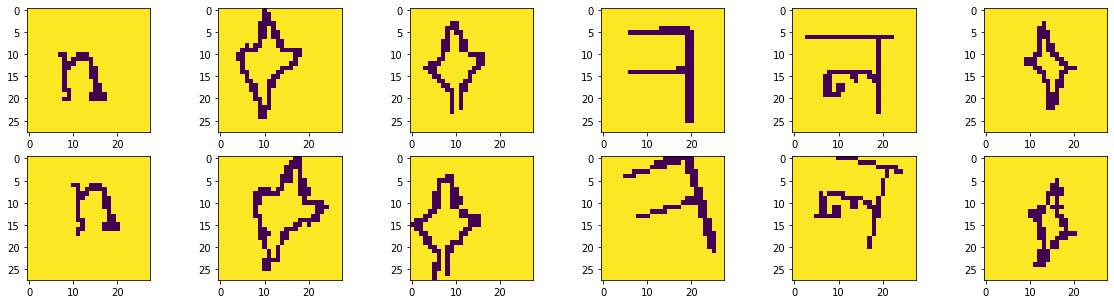

In [25]:
examples = train_data[0]
f, axes = plt.subplots(2, 6, figsize=(20,5))
[ax.imshow(examples[i]) for i, ax in enumerate(axes[0,:])]
[ax.imshow(augmentation(torch.Tensor(examples[i]).reshape((1,28,28))).reshape((28,28))) for i, ax in enumerate(axes[1,:])]

In [26]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10)

In [27]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = Siamese().to(device)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

TrainingProcedure = Trainer(model, device, criterion, optimizer, train_loader, val_loader, test_loader, epochs = 20)

train_loss, val_loss, train_accuracy, val_accuracy = TrainingProcedure.run_trainer()

  5%|▌         | 1/20 [00:55<17:31, 55.32s/it]

EPOCH: 01/20 LOSS: 0.6417 VAL-LOSS: 0.5779


 10%|█         | 2/20 [01:49<16:28, 54.93s/it]

EPOCH: 02/20 LOSS: 0.5968 VAL-LOSS: 0.5248


 15%|█▌        | 3/20 [02:44<15:31, 54.79s/it]

EPOCH: 03/20 LOSS: 0.5486 VAL-LOSS: 0.4747


 20%|██        | 4/20 [03:38<14:32, 54.50s/it]

EPOCH: 04/20 LOSS: 0.5104 VAL-LOSS: 0.4229


 25%|██▌       | 5/20 [04:33<13:36, 54.47s/it]

EPOCH: 05/20 LOSS: 0.4815 VAL-LOSS: 0.4058


 30%|███       | 6/20 [05:27<12:43, 54.50s/it]

EPOCH: 06/20 LOSS: 0.4604 VAL-LOSS: 0.3891


 35%|███▌      | 7/20 [06:22<11:48, 54.51s/it]

EPOCH: 07/20 LOSS: 0.4386 VAL-LOSS: 0.3713


 40%|████      | 8/20 [07:16<10:53, 54.42s/it]

EPOCH: 08/20 LOSS: 0.4220 VAL-LOSS: 0.3666


 45%|████▌     | 9/20 [08:10<09:58, 54.40s/it]

EPOCH: 09/20 LOSS: 0.4106 VAL-LOSS: 0.3460


 50%|█████     | 10/20 [09:05<09:03, 54.39s/it]

EPOCH: 10/20 LOSS: 0.3996 VAL-LOSS: 0.3520


 55%|█████▌    | 11/20 [09:59<08:08, 54.28s/it]

EPOCH: 11/20 LOSS: 0.3890 VAL-LOSS: 0.3487


 60%|██████    | 12/20 [10:52<07:11, 53.92s/it]

EPOCH: 12/20 LOSS: 0.3789 VAL-LOSS: 0.3238


 65%|██████▌   | 13/20 [11:45<06:15, 53.65s/it]

EPOCH: 13/20 LOSS: 0.3657 VAL-LOSS: 0.3191


 70%|███████   | 14/20 [12:38<05:21, 53.62s/it]

EPOCH: 14/20 LOSS: 0.3572 VAL-LOSS: 0.3107


 75%|███████▌  | 15/20 [13:31<04:27, 53.47s/it]

EPOCH: 15/20 LOSS: 0.3515 VAL-LOSS: 0.3080


 80%|████████  | 16/20 [14:25<03:33, 53.42s/it]

EPOCH: 16/20 LOSS: 0.3409 VAL-LOSS: 0.2960


 85%|████████▌ | 17/20 [15:18<02:40, 53.49s/it]

EPOCH: 17/20 LOSS: 0.3337 VAL-LOSS: 0.2956


 90%|█████████ | 18/20 [16:11<01:46, 53.35s/it]

EPOCH: 18/20 LOSS: 0.3302 VAL-LOSS: 0.2977


 95%|█████████▌| 19/20 [17:04<00:53, 53.25s/it]

EPOCH: 19/20 LOSS: 0.3194 VAL-LOSS: 0.2925


100%|██████████| 20/20 [17:58<00:00, 53.91s/it]

EPOCH: 20/20 LOSS: 0.3165 VAL-LOSS: 0.2817


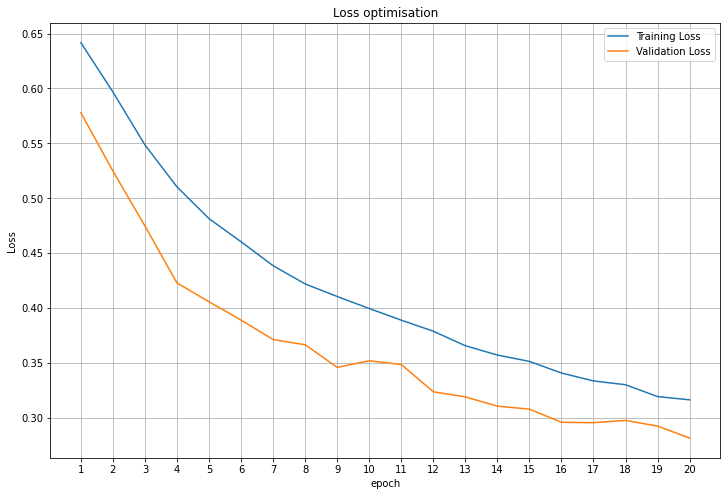

In [28]:
plot_training(train_loss, val_loss, 'Loss')

Check the test accuracy

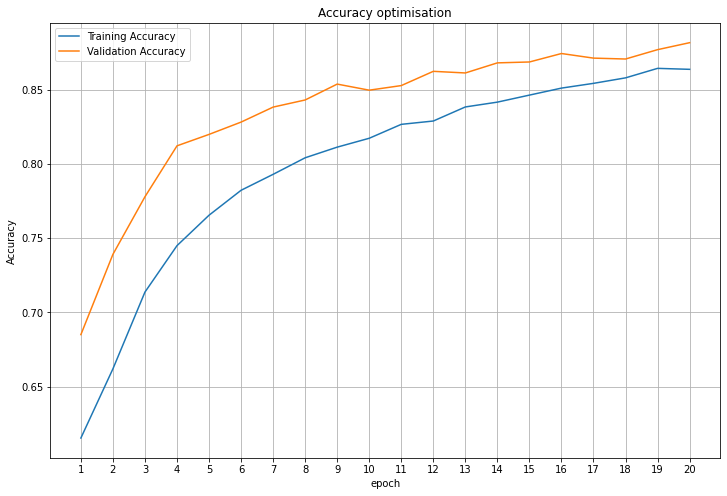

In [29]:
plot_training(train_accuracy, val_accuracy, 'Accuracy')

In [30]:
TrainingProcedure.evaluate()

Accuracy: 0.9282 

### Experiment with data augmentation with Contrastive Loss

In [31]:
class ContrastiveLoss(nn.Module):
    """
    """

    def __init__(self, model):
        super(ContrastiveLoss, self).__init__()
        self.model = model
        self.tau = nn.Parameter(torch.ones(1))

    def forward(self, input1, input2, target):
        relu = nn.ReLU()
        distance = self.model(input1, input2)
        out = (target)*0.5*(distance**2) + (1 - target)*(relu(self.tau - distance)**2)
        return out.mean()

In [32]:
class Siamese_Contrastive(nn.Module):
    def __init__(self):
        super(Siamese_Contrastive, self).__init__()
        self.conv = nn.Sequential(
             #1
            nn.Conv2d(1, 64, 3), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  
            nn.BatchNorm2d(64),
            #2
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),   
            nn.MaxPool2d(2),   
            nn.BatchNorm2d(128),
            #3
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        # the last layer of the model is the representation
        self.liner = nn.Sequential(nn.Linear(3*3*256, 128))

    def forward_one(self, x):
        #print(x.shape)
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        distance = torch.norm(out1 - out2, 2, dim=1)

        return distance

In [33]:
from tqdm import tqdm

class Trainer_Contrastive():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

        epoch_train_losses = []
        epoch_val_losses = []
        epoch_train_accuracy = []
        epoch_val_accuracy = []
        for epoch in tqdm(range(self.epochs)):
                 

            self.criterion.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for A, B, y in self.training_DataLoader:

                A, B, target = A.reshape(-1, 1, 28, 28).to(self.device), B.reshape(-1, 1, 28, 28).to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                #distance = self.model(A, B)  # one forward pass

                loss = self.criterion(A, B, target)  # calculate loss
                loss_value = loss.item()
                train_losses.append(loss_value)
                distance = self.criterion.model(A, B)
                out = (distance < self.criterion.tau).int()  

                correct += (out == target.view(-1)).sum().item()
                length += target.shape[0]


                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            epoch_train_losses.append(np.mean(train_losses))
            epoch_train_accuracy.append(np.round(correct/length, 5))

            self.criterion.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for A, B, y in self.validation_DataLoader:

                A, B, target = A.reshape(-1, 1, 28, 28).to(self.device), B.reshape(-1, 1, 28, 28).to(self.device), y.to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    #distance = self.model(A, B)   # one forward pass
                    loss = self.criterion(A, B, target) # calculate loss
                    distance = self.criterion.model(A, B)
                    out = (distance < self.criterion.tau).int()  

                    correct += (out == target.view(-1)).sum().item()
                    length += target.shape[0]

                    loss_value = loss.item()
                    valid_losses.append(loss_value)
            epoch_val_losses.append(np.mean(valid_losses))
            epoch_val_accuracy.append(np.round(correct/length, 5))

                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {epoch_train_losses[-1]:.4f}',end=' ')
            print(f'VAL-LOSS: {epoch_val_losses[-1]:.4f}',end='\n')

            #plot_training(epoch, np.round(epoch_train_losses, 5), np.round(epoch_val_losses, 5))
        return epoch_train_losses, epoch_val_losses, epoch_train_accuracy, epoch_val_accuracy


    def evaluate(self):

        self.criterion.eval()

        with torch.no_grad():
            correct = 0
            length = 0
            for A, B, y in self.testing_DataLoader:

                A, B, target = A.reshape(-1, 1, 28, 28).to(self.device), B.reshape(-1, 1, 28, 28).to(self.device), y.to(self.device)

                distance = self.criterion.model(A, B)
                out = (distance < self.criterion.tau).int()  

                correct += (out == target.view(-1)).sum().item()
                length += target.shape[0]
            
        print(f'Accuracy: {correct/length:.4f}',end=' ')


The number of epochs for the contrastive loss is smaller as after the 10th epoch the loss function for validation and training set is not changing

In [34]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = Siamese_Contrastive().to(device)

criterion = ContrastiveLoss(model).to(device)

optimizer = torch.optim.SGD(criterion.parameters(), lr=0.001, momentum=0.9)

TrainingProcedure2 = Trainer_Contrastive(model, device, criterion, optimizer, train_loader, val_loader, test_loader, epochs = 10)

train_loss, val_loss, train_accuracy, val_accuracy = TrainingProcedure2.run_trainer()

 10%|█         | 1/10 [01:01<09:10, 61.19s/it]

EPOCH: 01/10 LOSS: 0.6820 VAL-LOSS: 0.0438


 20%|██        | 2/10 [02:02<08:10, 61.31s/it]

EPOCH: 02/10 LOSS: 0.0377 VAL-LOSS: 0.0294


 30%|███       | 3/10 [03:03<07:08, 61.28s/it]

EPOCH: 03/10 LOSS: 0.0185 VAL-LOSS: 0.0122


 40%|████      | 4/10 [04:04<06:06, 61.15s/it]

EPOCH: 04/10 LOSS: 0.0124 VAL-LOSS: 0.0082


 50%|█████     | 5/10 [05:06<05:06, 61.21s/it]

EPOCH: 05/10 LOSS: 0.0092 VAL-LOSS: 0.0072


 60%|██████    | 6/10 [06:07<04:05, 61.26s/it]

EPOCH: 06/10 LOSS: 0.0070 VAL-LOSS: 0.0052


 70%|███████   | 7/10 [07:08<03:03, 61.29s/it]

EPOCH: 07/10 LOSS: 0.0058 VAL-LOSS: 0.0049


 80%|████████  | 8/10 [08:10<02:02, 61.31s/it]

EPOCH: 08/10 LOSS: 0.0049 VAL-LOSS: 0.0044


 90%|█████████ | 9/10 [09:11<01:01, 61.19s/it]

EPOCH: 09/10 LOSS: 0.0043 VAL-LOSS: 0.0041


100%|██████████| 10/10 [10:12<00:00, 61.23s/it]

EPOCH: 10/10 LOSS: 0.0038 VAL-LOSS: 0.0040


In [35]:
criterion.tau.detach()

tensor([0.0826], device='cuda:0')

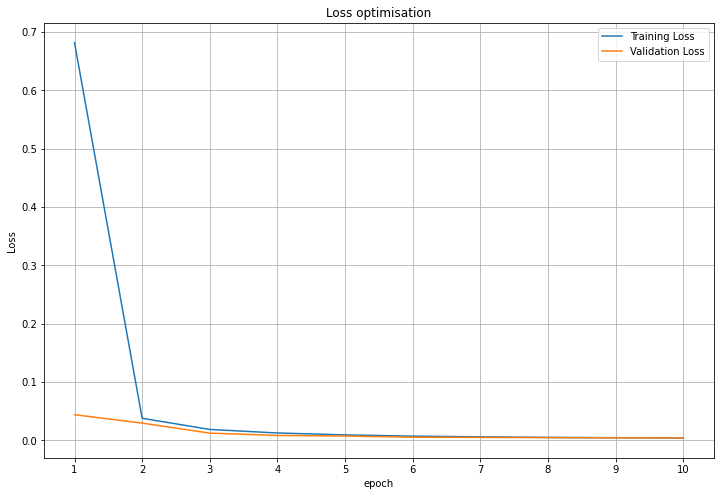

In [36]:
plot_training(train_loss, val_loss, 'Loss')

Check test accuracy:

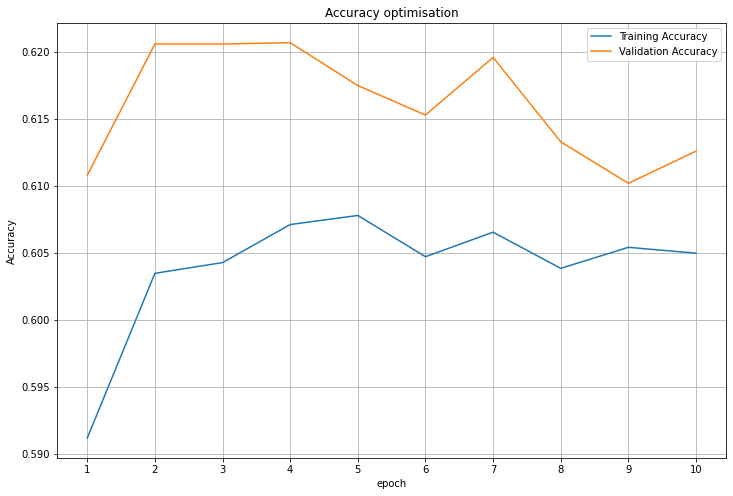

In [37]:
plot_training(train_accuracy, val_accuracy, 'Accuracy')

In [38]:
TrainingProcedure2.evaluate()

Accuracy: 0.6514 